# Predicting open loans

In [49]:
import joblib
import json
import pandas as pd
import loan_processing as lp
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import importlib as imp

## Business Case Assumptions


### Basic Idea

The basic assumption is that we are able to buy loans selectively from the pool of open loans. We can buy the loans at a discount and then collect the full amount from the borrower. 
We will set the average discount price to account for the risk of default, we estimate with the help of the model.
Since the positive class in model training is the default class, we will use the probability of default as a measure of risk.

The interest of the loan is already implicitly included in the monthly installments. After we buy the loan, the assumption is that the borrower will continue to pay the monthly installments, but they will be paid to us not (the new owners of the debt) and not to the original lender.

* `Buy Price` = Monthly nstallments * Time-to-maturity of the loan / (1 - Discount rate)
* `Expected Profit per loan` = Buy Price - Monthly Installments * Time-to-maturity of the loan 
* `Expected Total Profit`  = Sum of Expected Profits per loan * (1 - False negative rate)


## Prequisites

* Make current date flexible
* Determine the time-to-maturity
* Take interest rate from dataset and multiply it with the loan amount to get the interest amount
* Calculate the total expected profit

# Scenarios

* `True Positive` - In this case the model would suggest a default, we would **not buy the loan** and the borrower defaults
* `False Positive` - Model suggests a default, we **do not buy the loan**, but the borrower **does not default**
* `True Negative` - Model suggests the loan will be fully paid, we **buy the loan** and the borrower **does not default** = **Profit**
* `False Negative` - Model suggests the loan will be fully paid, we **buy the loan** and the borrower **defaults** resulting in a **full loss of the price we paid for the loan**

In [50]:
# Load active loans raw data

active_loans = pd.read_parquet('DATA/active_loans.parquet')


# Process date columns
date_cols = ['earliest_cr_line', 'last_credit_pull_d']
active_loans = lp.process_month_date(active_loans, date_cols)
active_loans = lp.process_year_month_date(active_loans, ['issue_d'])
active_loans = lp.process_percentages(active_loans, ['int_rate', 'revol_util'])
active_loans = lp.create_fico_features(active_loans)
active_loans = lp.create_target_columns(active_loans, 'loan_status', drop_target= True)
active_loans = lp.process_term(active_loans, 'term')

print(active_loans['issue_d'].min())
print(active_loans['issue_d'].max())

Target columns created: active_loan, default
2014-10-01 00:00:00
2018-12-01 00:00:00


In [51]:
time_of_invest = '2019-06-01'  # Set the time of investment
time_of_invest = pd.to_datetime(time_of_invest)  # Convert to datetime

info_cols = [
    'installment',
    'out_prncp',
    'int_rate',
    'funded_amnt',
    'term',
    'grade',
    'sub_grade',
    'home_ownership',
    'avg_fico_current',
    'fico_downgrade',
    'issue_d',
    'active_loan'
]

active_loans = active_loans[active_loans['out_prncp'] > active_loans['installment']]

active_info = active_loans[info_cols].copy()  # Create a copy of the columns to avoid direct modification

# Process and calculate required columns
# Using 'active_loans' instead of 'active_info' for the calculations
active_info = lp.calculate_loan_end_date(active_info, 'issue_d', 'term')
active_info = lp.calculate_time_to_maturity(active_info, 'loan_end_date', time_of_invest)

## Explore open loan data

### Prepare columns

In [62]:
# Load model and preprocessor
model_size = 'full'
model_date = '20250317'
model_version = '213829'


dropped_file = f'OUTPUT/Processing/dropped_columns_{model_date}_{model_version}.json'
model = joblib.load(f'OUTPUT/Models/best_xgboost_{model_size}_{model_date}_{model_version}.pkl')
preprocessor = joblib.load(f'OUTPUT/Processing/preprocessing_pipeline_{model_date}_{model_version}.pkl')

# Drop columns
with open(dropped_file, 'r') as file:
    drop_cols = json.load(file)

lp.drop_columns(active_loans, drop_cols, verbose = False)

y = active_loans['default']
X = active_loans.drop('default', axis=1).copy()

# Identify object columns that might contain categorical data
categorical_cols = X.select_dtypes(include=['object']).columns
for col in categorical_cols:
    X[col] = X[col].fillna('Unknown')

X.describe().T

len(X.columns)

# Preprocess data
X_processed = preprocessor.transform(X)

## Join all results

In [63]:
# Make the predictions

y_pred = model.predict_proba(X_processed)[:, 1]
# Merge predictions with original data
adf = pd.concat([active_info, pd.Series(y_pred, name='default_proba')], axis=1)

### Exploring the results

In [64]:
adf.sort_values(['time_to_maturity'], ascending=True).head(10)

problems = adf[adf['installment'] > adf['out_prncp']]
len(problems) / len(adf)

0.0

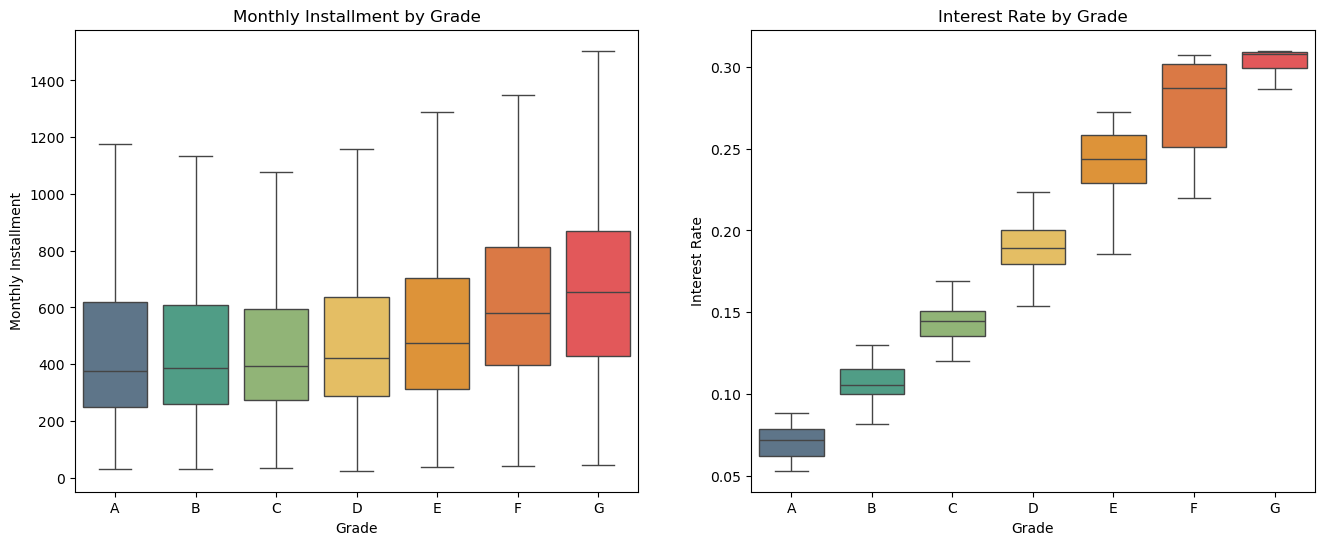

<Figure size 640x480 with 0 Axes>

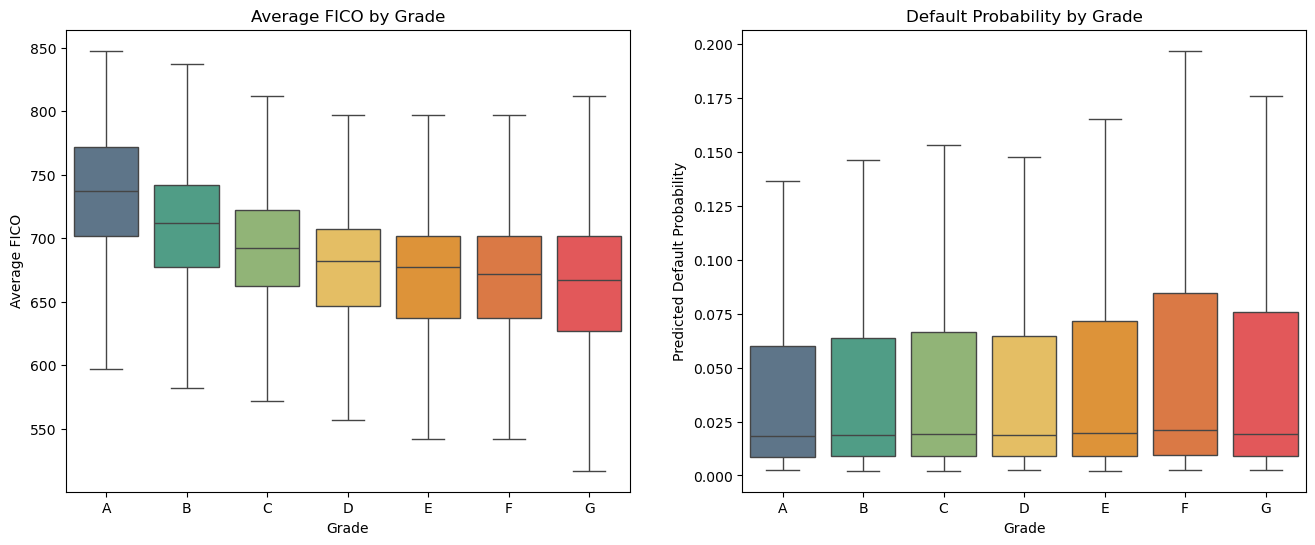

<Figure size 640x480 with 0 Axes>

In [65]:
# Show default probabilities and monthly installments by grade

grade_order = ['A', 'B', 'C', 'D', 'E', 'F', 'G']
subgrade_order = ['G5', 'G4', 'G3', 'G2', 'G1', 'F5', 'F4', 'F3', 'F2', 'F1', 'E5', 'E4', 'E3', 'E2', 'E1', 'D5', 'D4', 'D3', 'D2', 'D1', 'C5', 'C4', 'C3', 'C2', 'C1', 'B5', 'B4', 'B3', 'B2', 'B1', 'A5', 'A4', 'A3', 'A2', 'A1']
subgrade_order = subgrade_order[::-1]
col = {'A': '#577590', 'B': '#43aa8b', 'C': '#90be6d', 'D': '#f9c74f', 'E': '#f8961e', 'F': '#f3722c', 'G': '#f94144', 'None' : 'grey'}

fig, (installment, interest) = plt.subplots(1, 2, figsize=(16, 6))
installment.set_title('Monthly Installment by Grade')
installment = sns.boxplot(x='grade', y='installment', data=adf, order=grade_order, ax=installment, showfliers=False, hue='grade',palette=col)
installment.set_xlabel('Grade')
installment.set_ylabel('Monthly Installment')
installment.legend_.remove()
interest.set_title('Interest Rate by Grade')
interest = sns.boxplot(x='grade', y='int_rate', data=adf, order=grade_order, ax=interest, showfliers=False, hue='grade',palette=col)
interest.set_xlabel('Grade')
interest.set_ylabel('Interest Rate')
interest.legend_.remove()
plt.show()
plt.savefig('OUTPUT/Plots/grade_install+interest_boxplots.png')


fig, (fico, default) = plt.subplots(1, 2, figsize=(16, 6))
fico.set_title('Average FICO by Grade')
fico = sns.boxplot(x='grade', y='avg_fico_current', data=adf, order=grade_order, ax=fico, showfliers=False, hue='grade',palette=col)
fico.set_xlabel('Grade')
fico.set_ylabel('Average FICO')
fico.legend_.remove()
default.set_title('Default Probability by Grade')
default = sns.boxplot(x='grade', y='default_proba', data=adf, order=grade_order, ax=default, showfliers=False, hue='grade',palette=col)
default.set_xlabel('Grade')
default.set_ylabel('Predicted Default Probability')
default.legend_.remove()
plt.show()
plt.savefig('OUTPUT/Plots/grade_fico+default_boxplots.png')

## Getting the break-even discounts required for making a profit

Args:
    df (DataFrame): DataFrame with open loan data
    predictions (Series): Predicted probabilities of default
    threshold (float): Classification threshold
    historical_fn_rate (float): Historical false negative rate (% of predicted paid that default)
    recovery_rate (float): Recovery rate for defaulted loans
    tolerance (float): Acceptable error margin for break-even point
    max_iterations (int): Maximum number of iterations for binary search

In [161]:
# Get historical false negative rate (which in this case is 1 - recall)
model_report = pd.read_excel(f'OUTPUT/Metrics/model_metrics_{model_size}_{model_date}_{model_version}.xlsx', sheet_name='Classification Report', index_col=0)
conf_matrix = pd.read_excel(f'OUTPUT/Metrics/model_metrics_{model_size}_{model_date}_{model_version}.xlsx', sheet_name='Confusion Matrix', index_col=0)

recall = model_report['recall']['1']

historical_fn_rate = 1 - recall

print(f"False negative rate: {historical_fn_rate:.2%}")

# Get historical recoveries rates
with open('DATA/recovery_info.json') as f:
    recovery_info = json.load(f)
    recovery_info = pd.DataFrame(recovery_info, index=['recovery_rate']).T

threshold = 0.5

grade_discounts = {}

for grade in grade_order:
    grade_df = adf[adf['grade'] == grade].copy()
    recovery_rate = recovery_info.loc[grade, 'recovery_rate']
    grade_discounts[grade] = lp.calculate_break_even_discount(grade_df, grade_df['default_proba'], threshold, historical_fn_rate, recovery_rate, tolerance=0.001, max_iterations=100)

grade_discounts


False negative rate: 23.79%


{'A': 0.3113032286910311,
 'B': 0.30975229590694653,
 'C': 0.307438539190116,
 'D': 0.30480477403034456,
 'E': 0.30153477319981903,
 'F': 0.2980244834907353,
 'G': 0.2960948063991964}

In [171]:
imp.reload(lp)
roi_margin = 0.05

# Set threshold range to test profit
thresholds = np.arange(0.0, 1.0, 0.05)

# Initialize dictionaries and dataframes to store thresholds
grade_thresholds = {}
grade_best_results = {}

# Calculate profit by grade
for grade in grade_order:
    grade_df = adf[adf['grade'] == grade].copy()
    recovery_rate = recovery_info.loc[grade, 'recovery_rate']
    grade_thresholds[grade] = lp.calculate_profit_thresholds(grade_df, grade_df['default_proba'], thresholds, historical_fn_rate, recovery_rate, grade_discounts[grade] + roi_margin)
    grade_best_results[grade] = {}
    grade_best_results[grade]['threshold'] = lp.get_best_threshold(grade_thresholds[grade], kpi='roi')
    grade_best_results[grade] = lp.calculate_expected_profit(grade_df, grade_df['default_proba'], grade_best_results[grade]['threshold'], historical_fn_rate, recovery_rate, grade_discounts[grade] + roi_margin)

# Create a dataframe with the best results and reorder columns to make 'threshold' the first column
# Convert grade_best_results dictionary to a DataFrame
best_results_df = pd.DataFrame.from_dict(grade_best_results, orient='index')

# Reorder columns to make 'threshold' the first column
best_results_df = best_results_df.map('{:,.2f}'.format)
best_results_df


,threshold,total_loans,num_loans_selected,pct_loans_selected,expected_true_paid_count,expected_default_count,expected_return_true_paid,expected_return_defaults,total_expected_return,purchase_price,expected_profit,expected_roi
A,0.95,"104,471.00","104,351.00",1.00,"79,523.32","24,827.68","994,725,895.91","659,879.04","995,385,774.95","958,849,980.61","36,535,794.34",0.04
B,0.95,"126,622.00","125,071.00",0.99,"95,313.52","29,757.48","1,348,469,133.74","2,433,627.97","1,350,902,761.71","1,301,317,659.41","49,585,102.29",0.04
C,0.15,"120,662.00","97,839.00",0.81,"74,560.69","23,278.31","1,154,465,114.26","4,054,841.78","1,158,519,956.04","1,115,996,295.45","42,523,660.59",0.04
D,0.55,"57,211.00","51,871.00",0.91,"39,529.61","12,341.39","668,653,392.06","3,652,959.33","672,306,351.39","647,629,239.06","24,677,112.34",0.04
E,0.15,"17,070.00","13,460.00",0.79,"10,257.53","3,202.47","178,255,833.69","1,407,481.05","179,663,314.75","173,068,744.00","6,594,570.75",0.04
F,0.05,"3,563.00","2,244.00",0.63,"1,710.10",533.90,"38,416,234.13","404,155.48","38,820,389.61","37,395,480.99","1,424,908.62",0.04
G,0.90,"1,034.00",965.00,0.93,735.40,229.60,"17,898,333.59","214,226.11","18,112,559.70","17,447,735.29","664,824.41",0.04
